In [9]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np

In [13]:

def custom_metric(y1,y2):
    return cohen_kappa_score(y1, y2, weights = 'quadratic')

In [5]:


base_model = InceptionResNetV2(include_top=False, weights='imagenet')
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- we have 5 classes
predictions = Dense(5, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc', custom_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, None, None, 3 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, None, None, 3 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(299, 299),
        batch_size=20,
        classes=['0', '1', '2', '3', '4'],
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(299, 299),
        batch_size=20,
        classes=['0', '1', '2', '3', '4'],
        class_mode='categorical')


Found 10275 images belonging to 5 classes.
Found 2915 images belonging to 5 classes.


In [7]:

history = model.fit_generator(
        train_generator,
        steps_per_epoch=513,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=145)

Epoch 1/15
513/513 [==============================] - 124s 242ms/step - loss: 1.5511 - acc: 0.2529 - val_loss: 1.5615 - val_acc: 0.2745
Epoch 2/15
513/513 [==============================] - 117s 228ms/step - loss: 1.5473 - acc: 0.2609 - val_loss: 1.4950 - val_acc: 0.2667
Epoch 3/15
513/513 [==============================] - 117s 229ms/step - loss: 1.5407 - acc: 0.2680 - val_loss: 1.4822 - val_acc: 0.2850
Epoch 4/15
513/513 [==============================] - 117s 228ms/step - loss: 1.5027 - acc: 0.2854 - val_loss: 1.5333 - val_acc: 0.3285
Epoch 5/15
513/513 [==============================] - 118s 229ms/step - loss: 1.4862 - acc: 0.3064 - val_loss: 1.4549 - val_acc: 0.3237
Epoch 6/15
513/513 [==============================] - 118s 229ms/step - loss: 1.4677 - acc: 0.3178 - val_loss: 1.4477 - val_acc: 0.3212
Epoch 7/15
513/513 [==============================] - 118s 229ms/step - loss: 1.4540 - acc: 0.3245 - val_loss: 1.4453 - val_acc: 0.3147
Epoch 8/15
513/513 [============================

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


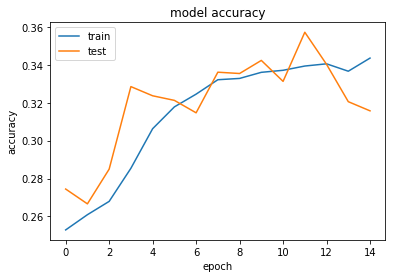

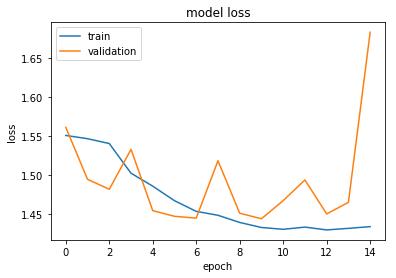

In [10]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [16]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:630]:
   layer.trainable = False
for layer in model.layers[630:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])
model.summary()


0 input_2
1 conv2d_204
2 batch_normalization_204
3 activation_204
4 conv2d_205
5 batch_normalization_205
6 activation_205
7 conv2d_206
8 batch_normalization_206
9 activation_206
10 max_pooling2d_5
11 conv2d_207
12 batch_normalization_207
13 activation_207
14 conv2d_208
15 batch_normalization_208
16 activation_208
17 max_pooling2d_6
18 conv2d_212
19 batch_normalization_212
20 activation_212
21 conv2d_210
22 conv2d_213
23 batch_normalization_210
24 batch_normalization_213
25 activation_210
26 activation_213
27 average_pooling2d_2
28 conv2d_209
29 conv2d_211
30 conv2d_214
31 conv2d_215
32 batch_normalization_209
33 batch_normalization_211
34 batch_normalization_214
35 batch_normalization_215
36 activation_209
37 activation_211
38 activation_214
39 activation_215
40 mixed_5b
41 conv2d_219
42 batch_normalization_219
43 activation_219
44 conv2d_217
45 conv2d_220
46 batch_normalization_217
47 batch_normalization_220
48 activation_217
49 activation_220
50 conv2d_216
51 conv2d_218
52 conv2d_221

activation_354 (Activation)     (None, None, None, 1 0           batch_normalization_354[0][0]    
__________________________________________________________________________________________________
conv2d_352 (Conv2D)             (None, None, None, 1 208896      block17_18_ac[0][0]              
__________________________________________________________________________________________________
conv2d_355 (Conv2D)             (None, None, None, 1 215040      activation_354[0][0]             
__________________________________________________________________________________________________
batch_normalization_352 (BatchN (None, None, None, 1 576         conv2d_352[0][0]                 
__________________________________________________________________________________________________
batch_normalization_355 (BatchN (None, None, None, 1 576         conv2d_355[0][0]                 
__________________________________________________________________________________________________
activation

In [17]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(
        train_generator,
        steps_per_epoch=513,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=145)

Epoch 1/30
513/513 [==============================] - 147s 287ms/step - loss: 1.4109 - acc: 0.3495 - val_loss: 1.4422 - val_acc: 0.3271
Epoch 2/30
513/513 [==============================] - 137s 267ms/step - loss: 1.3933 - acc: 0.3588 - val_loss: 1.4295 - val_acc: 0.3354
Epoch 3/30
513/513 [==============================] - 137s 267ms/step - loss: 1.3851 - acc: 0.3583 - val_loss: 1.4359 - val_acc: 0.3278
Epoch 4/30
513/513 [==============================] - 137s 267ms/step - loss: 1.3788 - acc: 0.3578 - val_loss: 1.4291 - val_acc: 0.3444
Epoch 5/30
513/513 [==============================] - 137s 268ms/step - loss: 1.3748 - acc: 0.3646 - val_loss: 1.4252 - val_acc: 0.3288
Epoch 6/30
513/513 [==============================] - 137s 268ms/step - loss: 1.3752 - acc: 0.3670 - val_loss: 1.4369 - val_acc: 0.3261
Epoch 7/30
513/513 [==============================] - 137s 268ms/step - loss: 1.3641 - acc: 0.3659 - val_loss: 1.4314 - val_acc: 0.3326
Epoch 8/30
513/513 [============================

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


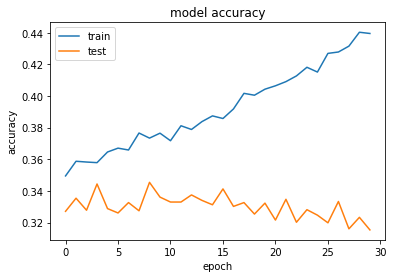

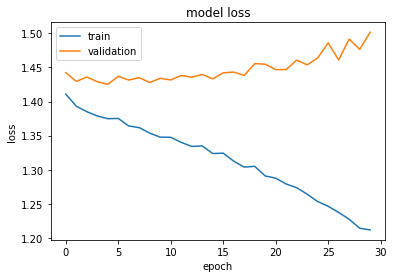

In [18]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [19]:
model.save('FineTuned_InceptionResNetV2_t10275_v2915_e15.h5')


In [5]:
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(299, 299),
    batch_size=10,
    classes=['0', '1', '2', '3', '4'],
    class_mode='categorical')

Found 1400 images belonging to 2 classes.


In [7]:

results = model.evaluate_generator(
    test_generator,
    verbose=1,
    steps=140)

140/140 [==============================] - 25s 179ms/step


In [8]:
print('Final test accuracy:', (results))


Final test accuracy: 0.15556803623794854


data/train/dog/0//c76e9857b-1.jpg


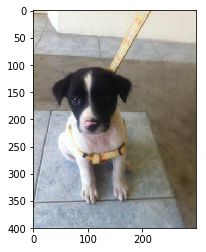

In [11]:
import random, os
from matplotlib import pyplot as plt
from PIL import Image

path = "data/train/dog/0/"
random_filename = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
print("data/train/dog/0/"+ os.sep + random_filename)
im=Image.open("data/train/dog/0/"+ os.sep + random_filename)
#im=Image.open('data/train/cat/0/e5728f078-1.jpg')
plt.imshow(im)
plt.show()

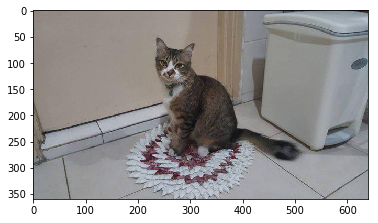

Predicted: [('n02747177', 'ashcan', 0.20809251), ('n02127052', 'lynx', 0.18331553), ('n02123045', 'tabby', 0.14549437)]


In [35]:
# predict one random image's prediction
path = "images"
random_filename = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])

img_path = "images"+ os.sep + random_filename
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

im=Image.open("images"+ os.sep + random_filename)
plt.imshow(im)
plt.show()

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])